# PRL paper: https://journals-aps-org.libaccess.sjlibrary.org/prl/pdf/10.1103/PhysRevLett.126.213601

# Supplemental Material: https://journals-aps-org.libaccess.sjlibrary.org/prl/supplemental/10.1103/PhysRevLett.126.213601/SiVcompare_SM8edits2.pdf

# article of nice plots: https://towardsdatascience.com/how-to-create-and-use-custom-matplotlib-style-sheet-9393f498063

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.integrate as spint
import cmath
# plt.style.use('seaborn-pastel')
plt.rcParams['font.family'] = 'sans-serif'
COLOR = 'w'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.edgecolor'] = 'k'
SIZE = 8
plt.rcParams['font.size'] = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['figure.titlesize'] = SIZE
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 800
# plt.rcParams['image.cmap'] = 'coolwarm'
plt.rcParams['image.cmap'] = 'viridis'

res = 100

# rcParams parameters https://matplotlib.org/stable/users/dflt_style_changes.html

# colorbar function

In [104]:
# @numba.jit
def colorbar(mappable, label='arb. units'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if label is not None:
        plt.ylabel(label)
    plt.sca(last_axes)
    return cbar

# multiple plot function

In [106]:
# @numba.jit
def slices_plots(
        databox,
        titles=None,
        figure_shape=[4, 4],
        figure_size=(11, 10),
        vertical_gap=0.15,
        horizontal_gap=0.15,
        shared_x_label=r'$\omega_t \quad$',
        shared_x_label_x_position=0.515,
        shared_x_label_y_position=0.09,
        shared_y_label=r'$\omega_\tau \quad$',
        shared_y_label_x_position=0.08,
        shared_y_label_y_position=0.5,
        shared_title=r'$\mathfrak{R} \left\{ \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau) \right\}$',
        shared_title_x_position=0.515,
        shared_title_y_position=0.93,
        share_x_axis=True,
        share_y_axis=True,
        colorbar_labels='arb. units', 
        EXTENT=(min(omega_t),
                max(omega_t), 
                min(omega_tau), 
                max(omega_tau))
        ):

    fig, ax = plt.subplots(
        figure_shape[0],  # row
        figure_shape[1],  # column
        figsize=figure_size,
        sharex=share_x_axis,
        sharey=share_y_axis,
        gridspec_kw={
            "hspace": vertical_gap,
            'wspace': horizontal_gap
        })

    for i in range(np.shape(databox)[0]):
        im = ax.flatten()[i].imshow(
            databox[i].T,
            origin='lower',
            extent=EXTENT
        )
        ax.flatten()[i].set_title(titles[i])
            
        if np.size(colorbar_labels)==1:
            if (i+1)%figure_shape[1]:
                colorbar(im, None)
            else:
                colorbar(im, colorbar_labels)
        else:
            colorbar(im, colorbar_labels[i])

    fig.suptitle(x=shared_title_x_position,
                 y=shared_title_y_position,
                 t=shared_title,
                 ha='center',
                 size=1.5*SIZE)

    if shared_x_label != None:  # shared x label
        fig.text(x=shared_x_label_x_position,
                 y=shared_x_label_y_position,
                 s=shared_x_label,
                 ha='center')

    if shared_y_label != None:  # shared y label
        fig.text(x=shared_y_label_x_position,
                 y=shared_y_label_y_position,
                 s=shared_y_label,
                 va='center',
                 rotation='vertical')

    plt.show()
    return fig

# complex square function

In [108]:
@numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
def abs2(x):
    return x.real**2 + x.imag**2

# complex phase

In [109]:
@numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
def phi(x):
    return cmath.phase(x)

# parameters

In [110]:
Delta_ZPL_0 = 1.
lambda_SO_gs = 0.5
lambda_SO_es = 0.1

t_para = 1.
t_perp = 0.1
d_gs = 1.
d_es = 1.
f_gs = -1.
f_es = -1.

sigma = 0.2 * Delta_ZPL_0
gamma_10 = 0.05 * sigma

\begin{equation}\label{eq:1}
    \Delta_{ZPL}(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}) = \Delta_{ZPL,0} + (t_{\parallel,es} - t_{\parallel,gs})\epsilon_{zz} + (t_{\perp,es} - t_{\perp,gs})(\epsilon_{xx} + \epsilon_{yy})
\end{equation}


In [111]:
@numba.jit
def Delta_ZPL(eps_xx=0., 
              eps_yy=0., 
              eps_zz=0.):
    return Delta_ZPL_0 + t_para*eps_zz + t_perp*(eps_xx + eps_yy)

\begin{equation}\label{eq:2}
    \Delta_{gs}(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \sqrt{\lambda_{SO,gs}^2 + 4[d_{gs}(\epsilon_{xx} - \epsilon_{yy}) + f_{gs} \epsilon_{yz}]^2 + 4[-2d_{gs} \epsilon_{xy} + f_{gs} \epsilon_{zx}]^2}
\end{equation}

In [112]:
@numba.jit
def Delta_gs(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):
    return np.sqrt( lambda_SO_gs**2. + 4.*(d_gs*(eps_xx - eps_yy) + f_gs*eps_yz)**2. + 4.*(-2.*d_gs*eps_xy + f_gs*eps_zx)**2. )

\begin{equation}\label{eq:3}
    \Delta_{es}(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \sqrt{\lambda_{SO,es}^2 + 4[d_{es}(\epsilon_{xx} - \epsilon_{yy}) + f_{es} \epsilon_{yz}]^2 + 4[-2d_{es} \epsilon_{xy} + f_{es} \epsilon_{zx}]^2}
\end{equation}

In [113]:
@numba.jit
def Delta_es(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):
    return np.sqrt( lambda_SO_es**2. + 4.*(d_es*(eps_xx - eps_yy) + f_es*eps_yz)**2. + 4.*(-2.*d_es*eps_xy + f_es*eps_zx)**2. )

\begin{equation}\label{eq:4}
    \rho (\omega_t, \omega_{\tau}, \epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \left( \frac{1}{\omega_t-[\Delta_{ZPL} \pm \Delta_{gs} \pm \Delta_{es} - i \gamma_{10}]} \right ) \left (\frac{1}{\omega_{\tau}+[\Delta_{ZPL} \pm \Delta_{gs} \pm \Delta_{es} + i \gamma_{10}]} \right)
\end{equation}


In [114]:
@numba.jit
def rho(omega_t, 
        omega_tau, 
        eps_xx = 0., 
        eps_yy = 0., 
        eps_zz = 0., 
        eps_yz = 0., 
        eps_xy = 0., 
        eps_zx = 0.):
    
    Del_ZPL = Delta_ZPL(eps_xx, 
                        eps_yy, 
                        eps_zz)
    
    Del_gs = Delta_gs(eps_xx, 
                      eps_yy, 
                      eps_yz, 
                      eps_xy, 
                      eps_zx)
    
    Del_es = Delta_es(eps_xx, 
                      eps_yy, 
                      eps_yz, 
                      eps_xy, 
                      eps_zx)
    
    sign = np.array([[ 1.,  1.,  1.,  1.], 
                     [ 1.,  1.,  1., -1.], 
                     [ 1.,  1., -1.,  1.], 
                     [ 1.,  1., -1., -1.], 
                     [ 1., -1.,  1.,  1.],
                     [ 1., -1.,  1., -1.], 
                     [ 1., -1., -1.,  1.], 
                     [ 1., -1., -1., -1.], 
                     [-1.,  1.,  1.,  1.], 
                     [-1.,  1.,  1., -1.],
                     [-1.,  1., -1.,  1.], 
                     [-1.,  1., -1., -1.], 
                     [-1., -1.,  1.,  1.], 
                     [-1., -1.,  1., -1.], 
                     [-1., -1., -1.,  1.],
                     [-1., -1., -1., -1.]])
    
    RHO = 1.j*np.zeros(np.shape(omega_t))
    
    for i in range(np.shape(sign)[0]):
        t_Lorentz = 1. / (omega_t - (Del_ZPL + sign[i,0]*Del_gs + sign[i,1]*Del_es - 1.j*gamma_10))
        tau_Lorentz = 1. / (omega_tau + (Del_ZPL + sign[i,2]*Del_gs + sign[i,3]*Del_es + 1.j*gamma_10))

        Rho = t_Lorentz * tau_Lorentz
        Rho /= np.sqrt(np.max(abs2(Rho)))
        RHO += Rho
        
    return RHO

# creating mesh

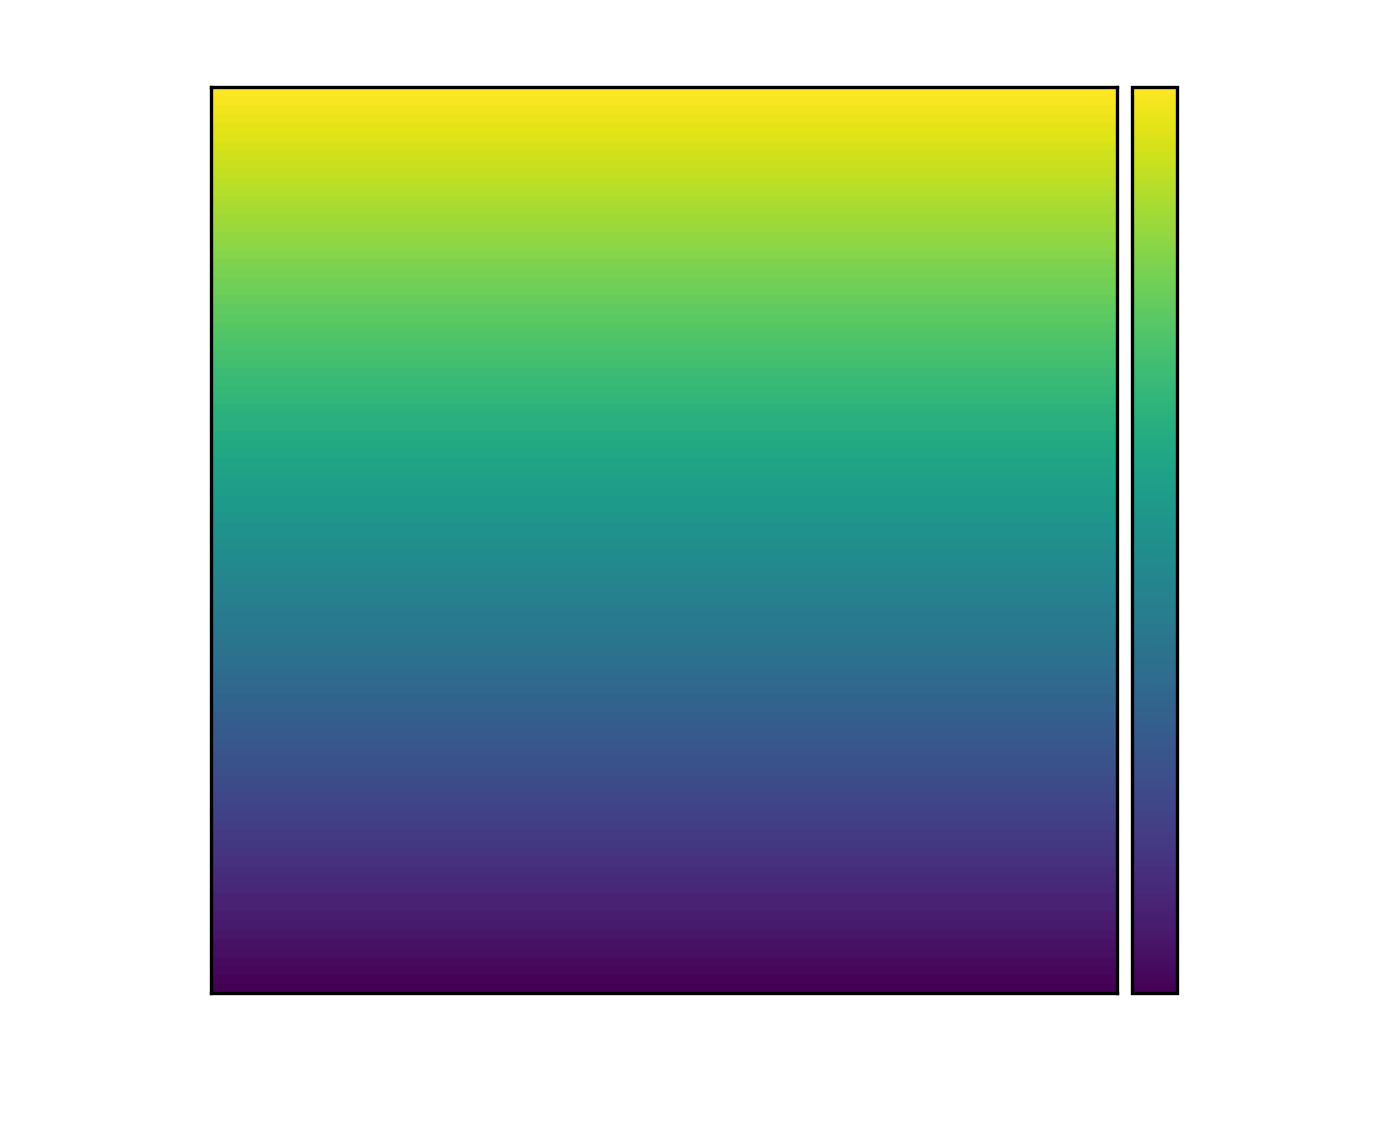

In [105]:
omega_t = np.linspace(0., 2., res)
omega_tau = np.linspace(-2., 0., res)
omega_t_mesh, omega_tau_mesh = np.meshgrid(omega_t, omega_tau, indexing='xy')
plt.figure()
im = plt.imshow(omega_tau_mesh, 
                origin='lower', 
                extent=(min(omega_t), 
                        max(omega_t), 
                        min(omega_tau), 
                        max(omega_tau)))
plt.xlabel(r'$\omega_t$')
plt.ylabel(r'$\omega_\tau$')
plt.title(r'$\omega_\tau$ mesh')
colorbar(im)
plt.show()

# Testing/sanity check, the mesh indexing convention can be weird

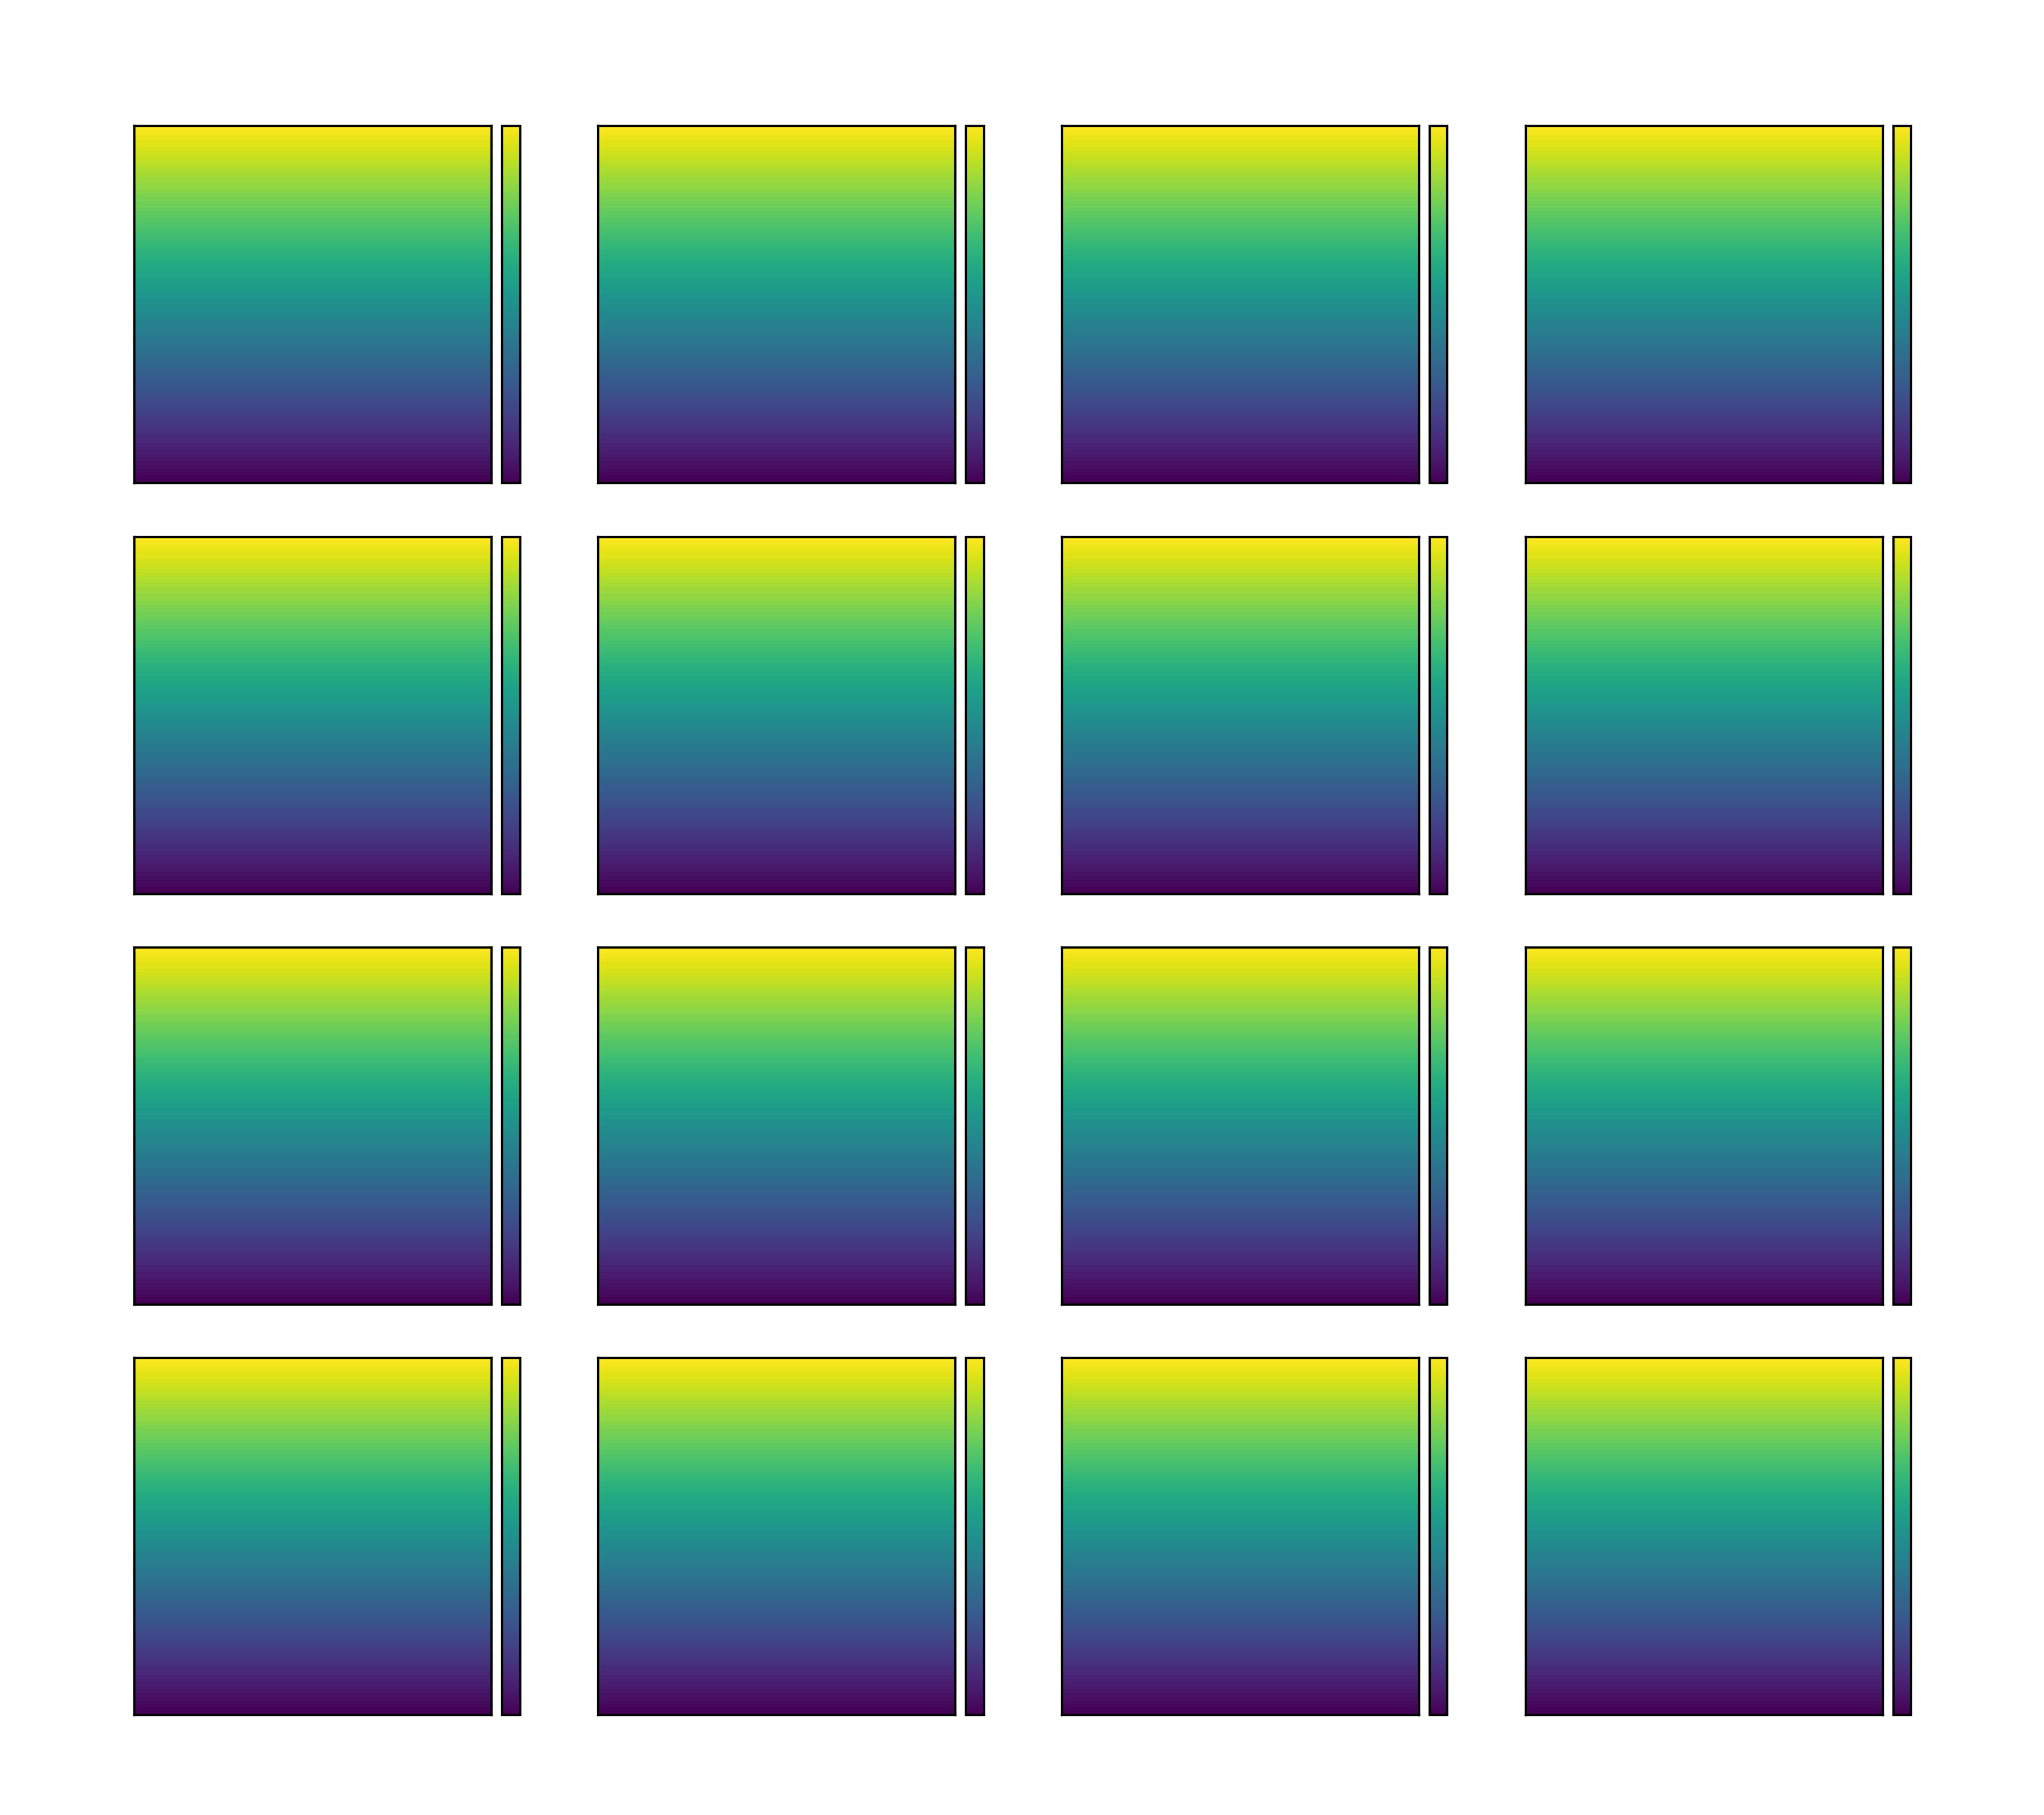

In [129]:
eps_zx_vals = np.linspace(-0.25 , 0.25, 16)
eps_zx_3Dmesh, omega_t_3Dmesh, omega_tau_3Dmesh = np.meshgrid(eps_zx_vals, 
                                                                omega_t, 
                                                                omega_tau, 
                                                                indexing='ij')

_ = slices_plots(omega_tau_3Dmesh, 
                 shared_title=r'$\omega_\tau$ 3D mesh',
                 titles = [r'$\epsilon_{zx} =$' f'{i:.2f}' for i in eps_zx_vals])

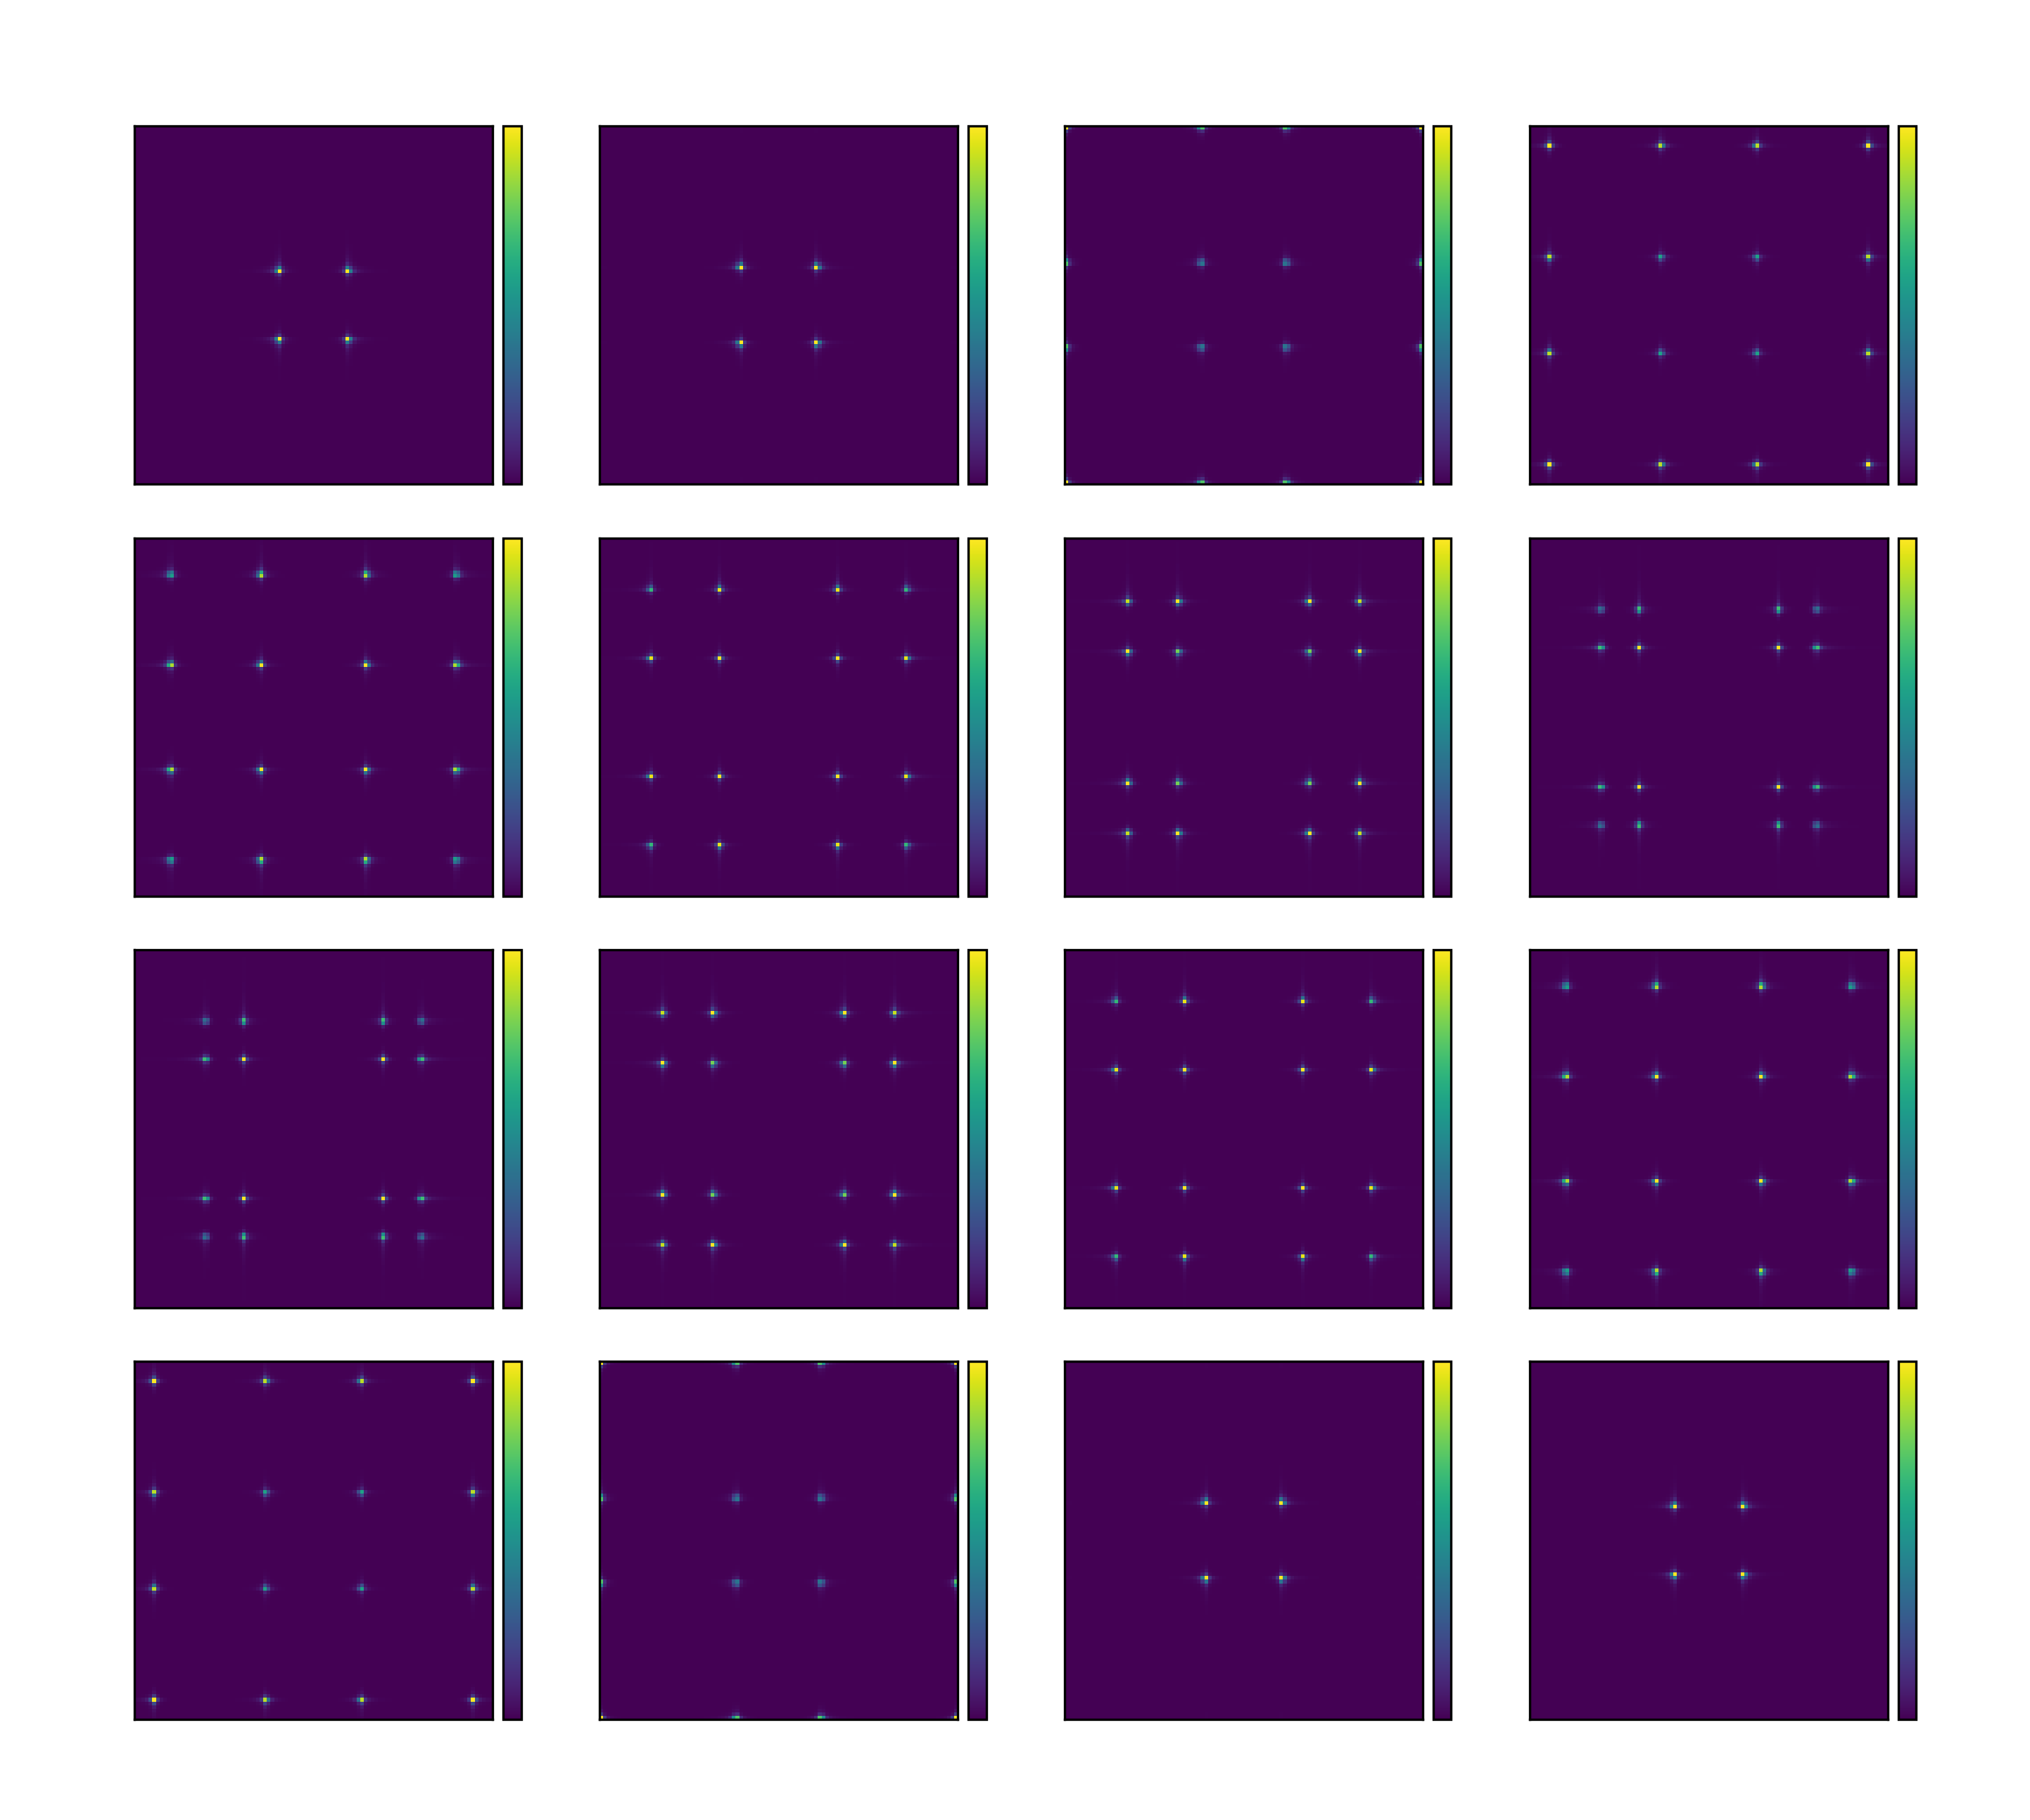

In [130]:
RHOs = rho(omega_t_3Dmesh, 
           omega_tau_3Dmesh, 
           eps_zx=eps_zx_3Dmesh)

_ = slices_plots(abs2(RHOs),
                 shared_title=r'$|\rho|^2$', 
                 titles = [r'$\epsilon_{zx} =$' f'{i:.2f}' for i in eps_zx_vals])

# Gaussian

\begin{equation}\label{eq:5}
    G \left (\epsilon_{ij}  \right ) \equiv \frac{1}{\sigma \sqrt{2 \pi}} exp \left[ \frac{-\epsilon_{ij}^2}{2 \sigma^2} \right] 
\end{equation}



In [132]:
@numba.jit
def G(eps_ij):
    return 1. / sigma / np.sqrt(2. * np.pi) * np.exp(-(eps_ij)**2. / 2. / sigma**2.)

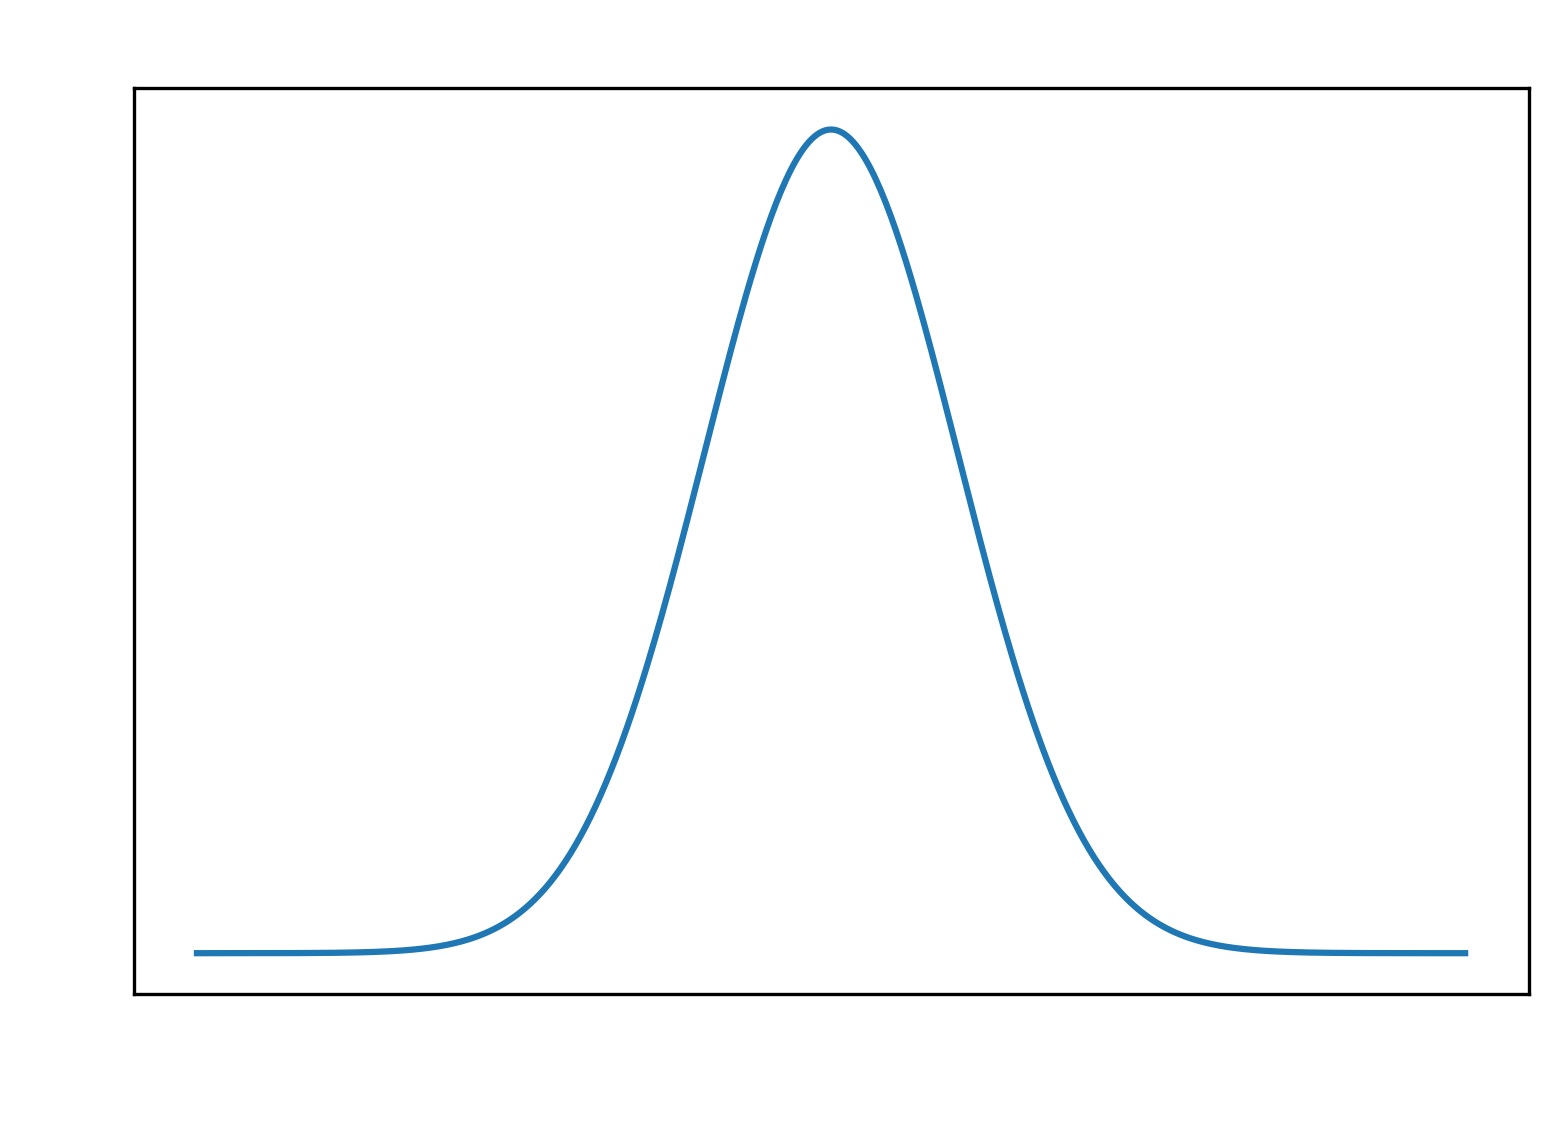

In [135]:
EPS_IJ = np.linspace(-1., 1., 500)
plt.plot(EPS_IJ, G(EPS_IJ))
plt.title(r'$ G \left (\epsilon_{ij} \right ) $')
plt.xlabel(r'$ \epsilon_{ij} $')
plt.show()

# Infinite integral

In [ ]:
@numba.jit
def infint(argu):
    return spint.quad_vec(argu, -np.inf, np.inf)

# computing the integral using https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad_vec.html

\begin{equation}\label{eq:6}
    I_{tot, PL}(\omega_t, \omega_\tau) \propto \displaystyle \int^{\infty}_{-\infty} G \left (\omega_{10} - \omega_{10}^{(unstrained)} \right ) \, \rho^{(4)}_{11,sig} (\omega_t, \omega_\tau, \omega_{10}) d \omega_{10}
\end{equation}




In [ ]:
argu = lambda omega10: G(omega10) * rho_11_sig_4(omega_t_mesh, omega_tau_mesh, omega10)
I_tot_PL, int_err_PL = infint(argu)

## Fig. S9(b)

In [ ]:
I_tot_PL_ReImAm = np.array([I_tot_PL.real, I_tot_PL.imag, abs2(I_tot_PL), phi(I_tot_PL)])
figPL = slices_plots(I_tot_PL_ReImAm, 
                      shared_title='PL detection sim.', 
                      shared_title_y_position=0.95,
                      figure_shape=[2,2], 
                      figure_size=[6,5.5],
                      titles=[r'$\mathfrak{R} \left\{I_{tot, PL} (\omega_t, \omega_\tau) \right\}$', 
                              r'$\mathfrak{I} \left\{I_{tot, PL} (\omega_t, \omega_\tau) \right\}$',
                              r'$             \left |I_{tot, PL} (\omega_t, \omega_\tau) \right |^2$',
                              r'$     \varphi \left (I_{tot, PL} (\omega_t, \omega_\tau) \right )$'],
                      horizontal_gap=0.06,
                      shared_y_label_x_position=0.04, 
                      shared_x_label_y_position=0.06)